## Example 11 - Simulation Exercise

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# tranport network analysis package
import transport_network_analysis.core as core

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

In [2]:
class quay:
    """quay class
    
    A quay has a limited length"""
    
    def __init__(self, quaylength):
        """initialization"""

#         self.env = env
        # quay properties
        self.quaylength = quaylength
        

In [3]:
quay1=quay(300)
print(quay1)

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
Quay = type('Quay', (core.Identifiable, core.Log, core.Locatable, core.HasResource, quay), {})

data_node_01 = {"env": [],
               "name": "anchorage",
               "geometry": shapely.geometry.Point(0, 0)}
data_node_02 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(2, 0)}
data_node_03 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(4, 0)}
data_node_04 = {"env": [],
               "name": "Node 3",
               "geometry": shapely.geometry.Point(5, 0)}
data_node_05 = {"env": [],
               "name": "tb5",
               "geometry": shapely.geometry.Point(9, 0)}
data_node_06 = {"env": [],
               "name": "b52",
               "geometry": shapely.geometry.Point(9, -1)}
data_node_07 = {"env": [],
               "name": "tb7",
               "geometry": shapely.geometry.Point(12, 0)}
data_node_08 = {"env": [],
               "name": "b62",
               "geometry": shapely.geometry.Point(12, -1)}
data_node_09 = {"env": [],
               "name": "tb9",
               "geometry": shapely.geometry.Point(15, 0)}
data_node_10 = {"env": [],
               "name": "b72",
               "geometry": shapely.geometry.Point(15, 1),
               "quaylength": 300}

anchor = Node(**data_node_01)
node_1 = Node(**data_node_02)
node_2 = Node(**data_node_03)
node_3 = Node(**data_node_04)
tb1    = Node(**data_node_05)
berth1 = Node(**data_node_06)
tb2    = Node(**data_node_07)
berth2 = Node(**data_node_08)
tb3    = Node(**data_node_09)
berth3 = Quay(**data_node_10)

nodes1 = [anchor, node_1, node_2, node_3, tb1, berth1, tb2, berth2, tb3, berth3]

at quay
('tb9', 'b72')


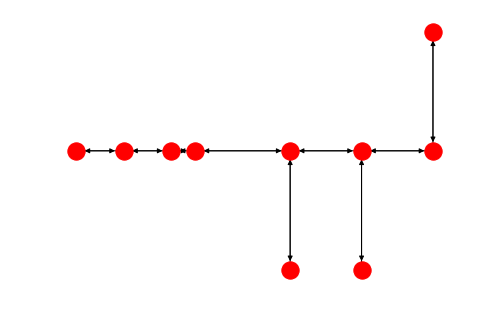

In [5]:
FG = nx.DiGraph()

positions = {}
it=-1
for node in nodes1:
    it+=1
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)
    if isinstance(node, quay):
        itnum=it
        print("at quay")
        obj = 'quay'
        

path = [[anchor, node_1], # From node 1 to node 2
        [node_1, node_2], # From node 2 to node 3
        [node_2, node_3], # From node 3 to node 4
        [node_3, tb1], # From node 3 to node 2
        [tb1, berth1],
        [berth1, tb1],
        [tb1, tb2],
        [tb2, berth2],
        [berth2, tb2],
        [tb2, tb3],
        [tb3, berth3],
        [berth3, tb3],
        [tb3, tb2],
        [tb2, tb1],
        [tb1, node_3], # From node 3 to node 4
        [node_3, node_2],
        [node_2, node_1],
        [node_1, anchor]] # From node 4 to node 3 - So one-way traffic is from node 1 to node 4

it=-2
for edge in path:
    it+=1
    if it==itnum:
        print((edge[0].name, edge[1].name))
        FG.add_edge(edge[0].name, edge[1].name, Object = "quay", weight = 1)
    else:
        FG.add_edge(edge[0].name, edge[1].name, weight = 1)

nx.draw(FG, positions)
plt.show()

In [6]:
# To show that moving from Node 4 to Node 1 is not possible
print("From b52 to b62:", nx.shortest_path_length(FG, "b52", "b72"), "steps.")
print("From b62 to anchorage:", nx.shortest_path_length(FG, "b72", "anchorage"), "steps.")
# print("From 4 to 1:", nx.shortest_path_length(FG, "Node 4", "Node 1"))

From b52 to b62: 4 steps.
From b62 to anchorage: 7 steps.


In [7]:
class turning_basin:
    """turning basin class
    
    A turning basin has a required turning time"""
    
    def __init__(self, turntime):
        """initialization"""

#         self.env = env
        # tb properties
        self.turntime = turntime

### Create vessels
Vessel without graph, but with shortest path.

In [8]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (core.Identifiable, core.Log, core.ContainerDependentMovable, 
                          core.HasResource, core.Routeable, core.Berthable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": shapely.geometry.Point(0, 0),  # lon, lat
               "capacity": 1_000,
               "quaylength": quay1.quaylength,
               "length": 100,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)
vessel2=vessel
vessel2.length=80

### Define paths

In [9]:
# First simulation is from Node 1 to Node 4
path_1 = nx.dijkstra_path(FG, "anchorage", "b72")

# Second simulation is from Node 4 to Node 1
path_2 = nx.dijkstra_path(FG, "b72", "anchorage")

paths = [path_1, path_2]
# paths = np.r_[path_1, path_2]

### Run simulation

In [10]:
def start(env, vessel):
    while True:
        vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
        yield from vessel.move()
        vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
        if vessel.geometry == nx.get_node_attributes(FG, "geometry")[vessel.route[-1]]:
            break

In [11]:
for path in enumerate(paths):
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())
    
    # Add graph to environment
    env.FG = FG
    
    # Add environment and path to the vessel
    vessel.env = env
    vessel.route = path[1]
    vessel.service_time = 18000
#     vessel.quay = core.quay(300)

    # Start the simulation
    env.process(start(env, vessel))
    env.run()
    print("Simulation of path {} took {} seconds".format(path[0] + 1, int(env.now)))

Vessel number 1 at quay, service time is 18000 sec
Remaining available quay length is 220.0 m.
Simulation of path 1 took 1553672493 seconds
Simulation of path 2 took 1553765067 seconds


### Testing

In [12]:
for geo in vessel.log["Geometry"]:
    print(geo.x, geo.y)

0.0 0.0
0.0 0.0
2.0 0.0
2.0 0.0
4.0 0.0
4.0 0.0
5.0 0.0
5.0 0.0
9.0 0.0
9.0 0.0
12.0 0.0
12.0 0.0
15.0 0.0
15.0 1.0
15.0 1.0
15.0 1.0
15.0 0.0
15.0 0.0
12.0 0.0
12.0 0.0
9.0 0.0
9.0 0.0
5.0 0.0
5.0 0.0
4.0 0.0
4.0 0.0
2.0 0.0
2.0 0.0
0.0 0.0
0.0 0.0


In [13]:
vessel.log["Timestamp"]

[datetime.datetime(2019, 3, 7, 19, 51, 41),
 datetime.datetime(2019, 3, 7, 19, 51, 41),
 datetime.datetime(2019, 3, 10, 9, 42, 19, 981586),
 datetime.datetime(2019, 3, 10, 9, 42, 19, 981586),
 datetime.datetime(2019, 3, 12, 23, 32, 58, 963173),
 datetime.datetime(2019, 3, 12, 23, 32, 58, 963173),
 datetime.datetime(2019, 3, 14, 6, 28, 18, 453966),
 datetime.datetime(2019, 3, 14, 6, 28, 18, 453966),
 datetime.datetime(2019, 3, 19, 10, 9, 36, 417139),
 datetime.datetime(2019, 3, 19, 10, 9, 36, 417139),
 datetime.datetime(2019, 3, 23, 6, 55, 34, 889519),
 datetime.datetime(2019, 3, 23, 6, 55, 34, 889519),
 datetime.datetime(2019, 3, 27, 3, 41, 33, 361899),
 datetime.datetime(2019, 3, 27, 8, 41, 33, 361899),
 datetime.datetime(2019, 3, 7, 19, 51, 41),
 datetime.datetime(2019, 3, 7, 19, 51, 41),
 datetime.datetime(2019, 3, 9, 2, 34, 35, 388558),
 datetime.datetime(2019, 3, 9, 2, 34, 35, 388558),
 datetime.datetime(2019, 3, 12, 23, 20, 33, 860938),
 datetime.datetime(2019, 3, 12, 23, 20, 33,

In [14]:
wgs84 = pyproj.Geod(ellps='WGS84')
distance_path_1 = 0
distance_path_2 = 0

for node in enumerate(path_1):
    orig = nx.get_node_attributes(FG, "geometry")[path_1[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_1[node[0] + 1]]

    distance_path_1 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_1):
                break

for node in enumerate(path_2):
    orig = nx.get_node_attributes(FG, "geometry")[path_2[node[0]]]
    dest = nx.get_node_attributes(FG, "geometry")[path_2[node[0] + 1]]

    distance_path_2 += int(wgs84.inv(shapely.geometry.asShape(orig).x, shapely.geometry.asShape(orig).y, 
                                     shapely.geometry.asShape(dest).x, shapely.geometry.asShape(dest).y)[2])
    
    if node[0] + 2 == len(path_2):
                break

In [15]:
edge

[<__main__.Site at 0x2450f4c36d8>, <__main__.Site at 0x2450f4c36a0>]